计算谱半径...
MSE = 5.886231290973594e-06


TypeError: only length-1 arrays can be converted to Python scalars

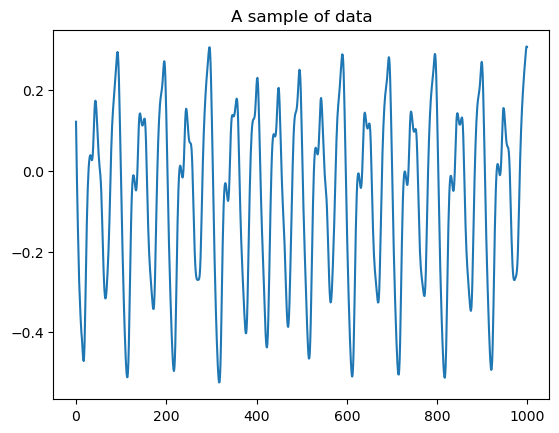

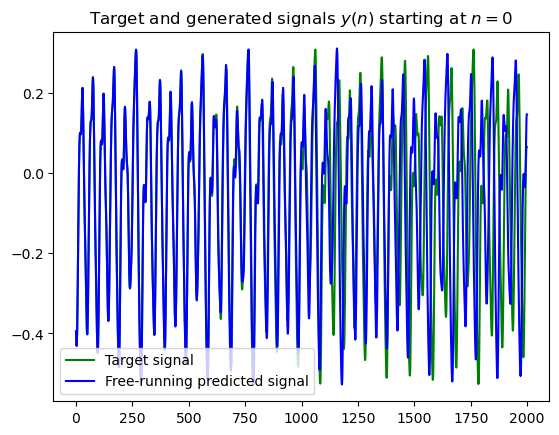

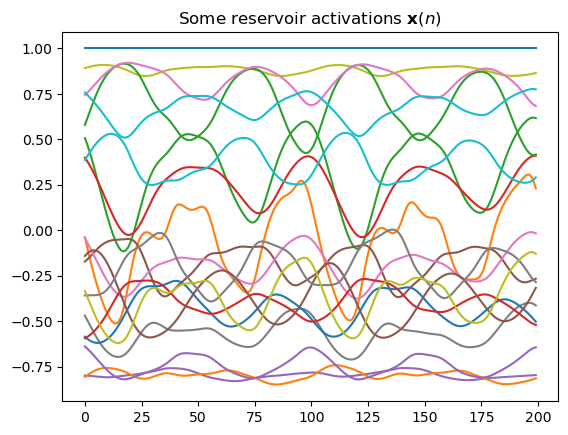

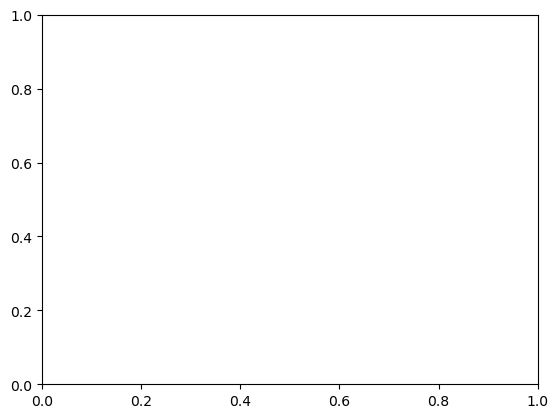

In [1]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukoševi�?ius 2012
http://minds.jacobs-university.de/mantas
"""
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
 
# 加载数据
#前2000个数据用来训练，2001-4000的数据用来测试。训练数据中，前100项用来初始化储备池，以让储备池中形成良好的回声之后再开始训练。
trainLen = 2000
testLen = 2000
initLen = 100
 
data = loadtxt('MackeyGlass_t17.txt')
 
# 绘制前1000条数据
figure(10).clear()
plot(data[0:1000])
title('A sample of data')
 
# 生成ESN储层
inSize = outSize = 1   # inSize 输入维数 K
resSize = 1000     # 储备池规模 N
a = 0.3 # 可以看作储备池更新的速度，可不加，即设为1.
 
random.seed(42)
#随机初始化 Win 和 W
Win = (random.rand(resSize, 1+inSize)-0.5) * 1   # 输入矩阵 N * (1+K)
W = random.rand(resSize, resSize)-0.5    # 储备池连接矩阵 N * N
 
# 对W进行防缩，以满足稀疏的要求。
# 方案 1 - 直接缩放 (快且有脏数据, 特定储层): W *= 0.135 
# 方案 2 - 归一化并设置谱半径 (正确, 慢):
print ('计算谱半径...')
rhoW = max(abs(linalg.eig(W)[0]))   # linalg.eig(W)[0]:特征值   linalg.eig(W)[1]:特征向量
W *= 1.25 / rhoW
 
# 为设计（收集状态）矩阵分配内存
X = zeros((1+inSize+resSize, trainLen-initLen))   # 储备池的状态矩阵x(t)：每一列是每个时刻的储备池状态。后面会转置
# 直接设置相应的目标矩阵
Yt = data[None, initLen+1:trainLen+1]    #输出矩阵:每一行是一个时刻的输出
 
# 输入所有的训练数据，然后得到每一时刻的输入值和储备池状态。
x = zeros((resSize, 1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1, u)) ) + dot( W, x ) )   # vstack((1, u)):将偏置量1加入输入序列
    if t >= initLen:   # 空转100次后，开始记录储备池状态
        X[:, t-initLen] = vstack((1, u, x))[:, 0]
    
# 使用Wout根据输入值和储备池状态去拟合目标值，这是一个简单的线性回归问题，这里使用的是岭回归(Ridge Regression)。
reg = 1e-8  # 正则化系数
X_T = X.T
# Wout:  1 * 1+K+N
Wout = dot( dot(Yt, X_T), linalg.inv( dot(X, X_T) + \
    reg*eye(1+inSize+resSize) ) )   # linalg.inv矩阵求逆；numpy.eye()生成对角矩阵，规模:1+inSize+resSize，默认对角线全1，其余全0
#Wout = dot( Yt, linalg.pinv(X) )
 
# 使用训练数据进行前向处理得到结果
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = zeros((outSize, testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1, u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1, u, x)) )   # 输出矩阵(1 * 1+K+N)*此刻状态矩阵(1+K+N * 1)=此刻预测值
    Y[:,t] = y    # t时刻的预测值   Y: 1 * testLen
    # 生成模型
    u = y
    # 预测模型
    #u = data[trainLen+t+1] 
 
# 计算第一个errorLen时间步长的MSE
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - Y[0, 0: errorLen] ) ) / errorLen
print ('MSE = {0}'.format( str( mse ) ))
    
# 绘制测试集的真实数据和预测数据
figure(1).clear()
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])
 
# 绘制储备池中前200个时刻状态(x(t))的前20个储层结点值
figure(2).clear()
plot( X[0:20,0:200].T )
title('Some reservoir activations $\mathbf{x}(n)$')
 
# 绘制输出矩阵
figure(3).clear()
bar( range(1+inSize+resSize), Wout.T )
title('Output weights $\mathbf{W}^{out}$')
 
show()